# Cartoon stylization

The method adopted to perform a cartoon stylization of an image was the Extended Difference of Gaussians (XDoG). The paper can be accessed here:

https://www.kyprianidis.com/p/cag2012/winnemoeller-cag2012.pdf

The DoG is the diffence of two gaussians function. It is a good and efficiente aproximation of the second order derivative Laplacian of Gaussian (LoG).

\begin{align}
 D_{\sigma,k,\gamma} = G_{\sigma}(x) - \gamma G_{k,\sigma}(x)
\end{align}

$k$ is a scale factor recommended to be 1.6 (for a good trade-off between accurate approximation and adequate sensitivity)

After applying the DoG is necessary to threshold the image. The technique applied was the soft threshold, which is calculated by:

$$ f(n) =
  \begin{cases}
    1       & \quad \text{if } x > \epsilon\\
    1 + tanh(\phi \cdot x) & \quad \text{if } otherwise
  \end{cases}
$$


In [130]:
#imports
import numpy as np
import imageio
import matplotlib.pyplot as plt
import math
import cv2 as cv

In [93]:
def euclidean_distance(x,y):
    """ Function to perform euclidean distance """
    return math.sqrt(x**2 + y**2)

def gaussian_kernel(x, sigma):
    """Function to compute gaussian kernel"""
    gaussiank = (1 / (2*math.pi* (sigma**2))) * np.exp(-1 * (x**2) / (2 * (sigma**2)))  
    
    return gaussiank

def gaussian_filter(n, sigma):
    """Function to compute the gaussian filter"""
    gs = np.zeros([n,n])
    a = int((n-1) / 2)
    for i in range(n):
        for j in range(n):
            gs[i,j] = gaussian_kernel(euclidean_distance(i-a,j-a),sigma)
    
    return gs

def Dog(input_img, n, k, sigma, gamma):
    """Function to perform the difference of gaussians technique
        input_img => grayscale image
        n => gaussian filter dimension
        k => scale parameter 
        sigma => spacial scale 
        gamma => sensitivity of the edge detector       
    """
    
    gf1 = gaussian_filter(n, sigma)
    # k is 1.6 for a good trade-off between accurate approximation and adequate sensitivity
    gf2 = gaussian_filter(n, k*sigma) 
    
    a = int((n-1) / 2)
    
    dog = gf1 - (gamma * gf2) # gamma = 0.98
    
    f = np.pad(input_img, (a,a), 'constant').astype(np.int32)
    

    N,M = f.shape
    g = np.array(f, copy=True)
    g = np.zeros(input_img.shape)
    for x in range(a,N-a):
        
           for y in range(a,M-a):
                sub_f = f[ x-a : x+a+1 , y-a:y+a+1 ]
                g[x-a,y-a] = np.sum(np.multiply(sub_f, dog))
                
    return g

def soft_threshold(img, epsilon, phi):
    """Function to compute the soft threshold
       img => the grayscale image
       epsilon => ir controls the level above which the luminance adjustmentes will become white
       phi => it controls the slope of the falloff
    """
    out = np.array(img, copy=True)
    N,M = img.shape
    for i in range(N):
        for j in range(M):
            if img[i,j] < epsilon:
                out[i,j] = 1
            else:
                out[i,j] = 1 + np.tanh(phi*img[i,j])
    return out

def mean_threshold(img):
    """Function to compute the mean threshold"""
    mean = np.mean(img)
    
    out = np.array(img, copy=True)
    N,M = img.shape
    for i in range(N):
        for j in range(M):
            if img[i,j] <= mean:
                out[i,j] = 1
            else:
                out[i,j] = 0
    return out


def combine_color_edges(img, edge):
    """Function to combine the colored image with the edges"""
    R = img[:,:,0]
    G = img[:,:,1]                                                
    B = img[:,:,2] 
    
    N,M = edge.shape
    
    for i in range(N):
        for j in range(M):
            if int(edge[i,j]) == 1:
                R[i,j] = 0
                G[i,j] = 0
                B[i,j] = 0
             
    img_out =  np.array(img, copy=True).astype(np.uint32)
    img_out[:,:,0] = np.clip(R, 0, 255)
    img_out[:,:,1] = np.clip(G, 0, 255)
    img_out[:,:,2] = np.clip(B, 0, 255)
    
    return img_out


def color_slot(pixel):
    """Function to compute new value of the pixel in color quantization"""
    
    # each RGB chanel has 6 options now, which means 6*6*6 = 216 colors
    if pixel >= 0 and pixel < 8:
        return 0
    if pixel >= 8 and pixel < 16:
        return 8
    if pixel >= 16 and pixel < 32:
        return 16
    if pixel >= 32 and pixel < 64:
        return 32
    if pixel >= 64 and pixel < 128:
        return 64
    if pixel >= 128 and pixel < 256:
        return 255


def color_quantization(img):
    """Function to reduce the color range of the image"""
    R = img[:,:,0]
    G = img[:,:,1]                                                
    B = img[:,:,2] 
    
    N,M = R.shape
    
    # performin the color thresold in each RGB channel
    for i in range(N):
        for j in range(M):
            R[i,j] = color_slot(R[i,j])
            G[i,j] = color_slot(G[i,j])
            B[i,j] = color_slot(B[i,j])
    
    # put the channels RGB together again
    img_out =  np.array(img, copy=True).astype(np.uint32)
    img_out[:,:,0] = np.clip(R, 0, 255)
    img_out[:,:,1] = np.clip(G, 0, 255)
    img_out[:,:,2] = np.clip(B, 0, 255)
    
    return img_out 

## First Example

(-0.5, 639.5, 799.5, -0.5)

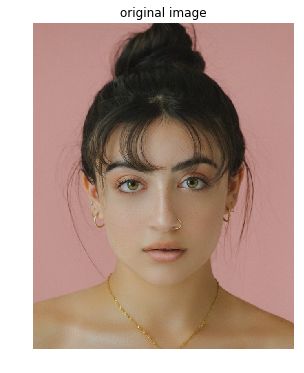

In [92]:
# load the image
filename = "image/jimmy-fermin-bqe0J0b26RQ-unsplash.jpg"
img = cv.imread(filename)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(6,6)) 
plt.imshow(img_rgb, cmap="gray", vmin=0, vmax=255)
plt.title("original image")
plt.axis('off')

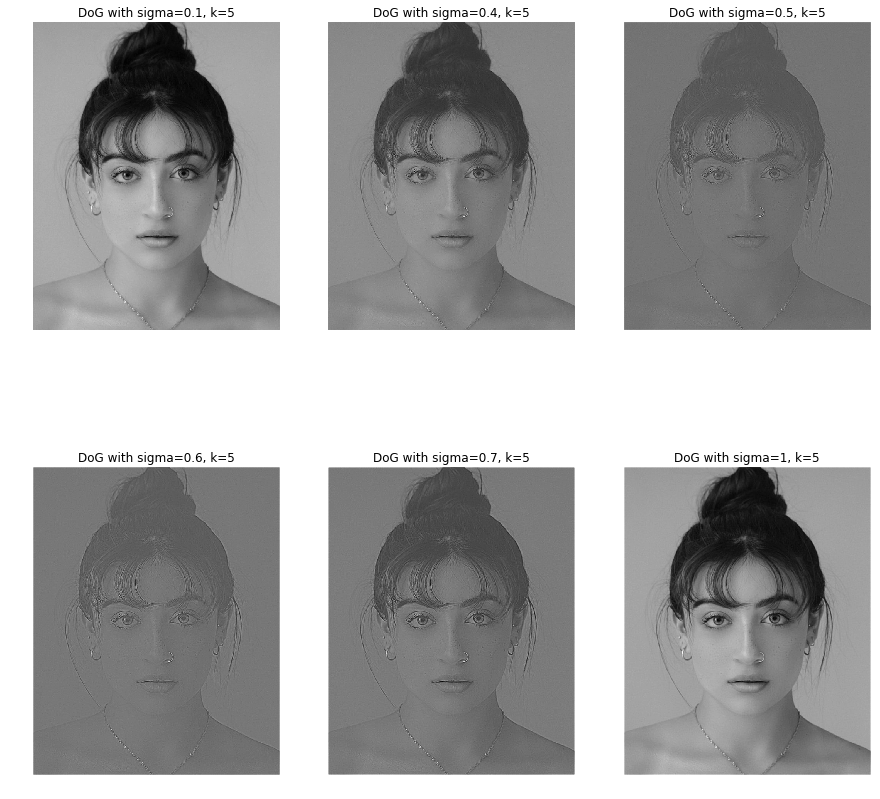

In [42]:
plt.figure(figsize=(15,15)) 
for idx,sigma in enumerate([0.1, 0.4, 0.5, 0.6, 0.7, 1]):
    dog = Dog(img_gray, 5, 1.6,  sigma, 0.98)
    plt.subplot(2,3,idx+1)
    plt.imshow(dog, cmap="gray")
    plt.title('DoG with sigma=' + str(sigma) + ', k=' + str(5))
    plt.axis('off')

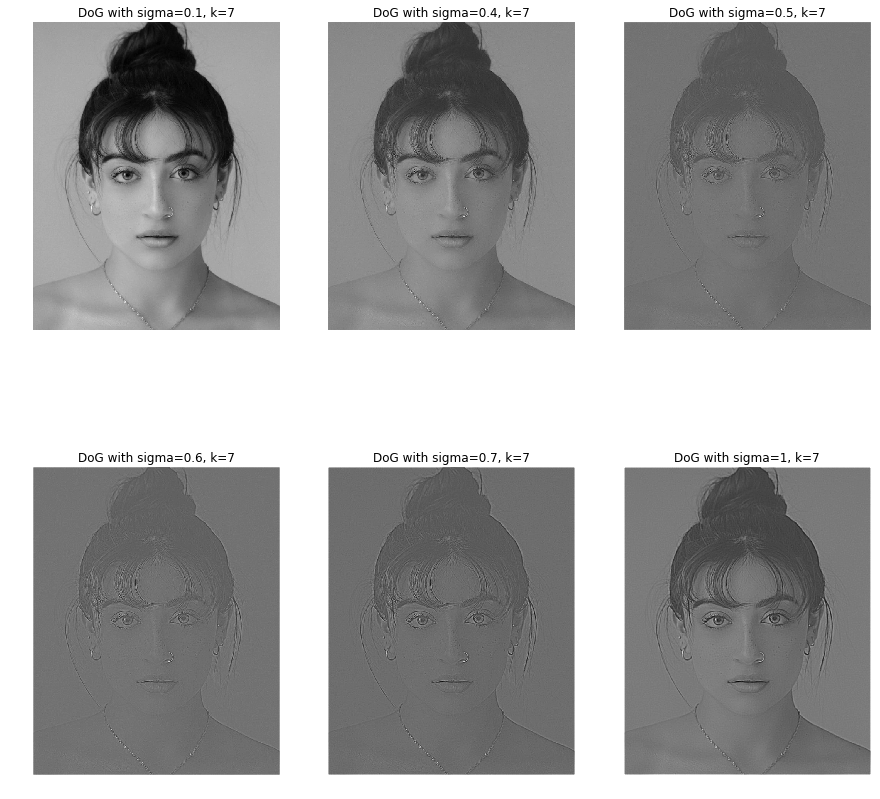

In [63]:
plt.figure(figsize=(15,15)) 
for idx,sigma in enumerate([0.1, 0.4, 0.5, 0.6, 0.7, 1]):
    dog = Dog(img_gray, 7, 1.6,  sigma, 0.98)
    plt.subplot(2,3,idx+1)
    plt.imshow(dog, cmap="gray")
    plt.title('DoG with sigma=' + str(sigma) + ', k=' + str(7))
    plt.axis('off')

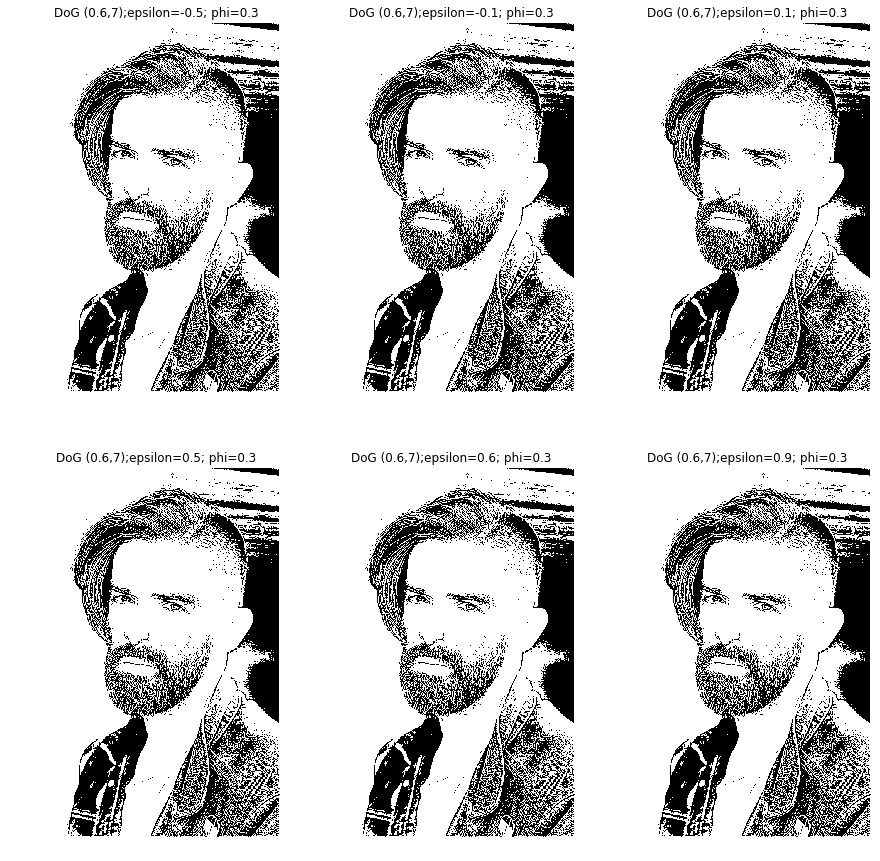

In [128]:
img_dog = Dog(img_gray, 5, 1.6,  0.7, 0.98)

plt.figure(figsize=(15,15)) 
for idx,epsilon in enumerate([-0.5, -0.1, 0.1, 0.5, 0.6, 0.9]):
    dog_t = soft_threshold(img_dog, epsilon, 0.3)
    dog_tt = mean_threshold(dog_t)
    plt.subplot(2,3,idx+1)
    plt.imshow(255 - dog_tt, cmap="gray")
    plt.title('DoG (0.6,7);' + 'epsilon=' + str(epsilon) + '; phi=0.3')
    plt.axis('off')

In [96]:
img_color_smooth = cv.bilateralFilter(img_rgb, d=9, sigmaColor=150, sigmaSpace=150)
img_color_qt = color_quantization(img_rgb)

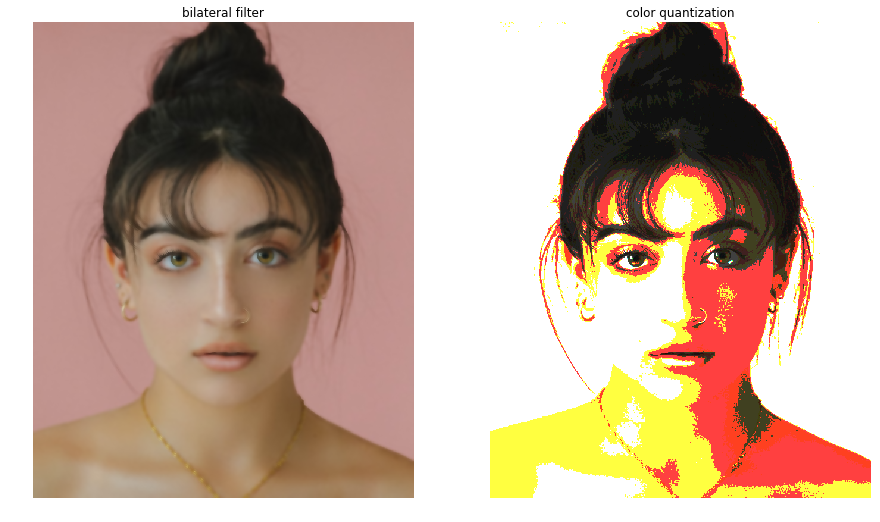

In [97]:
plt.figure(figsize=(15,15)) 
plt.subplot(121)
plt.imshow(img_color_smooth)
plt.title("bilateral filter")
plt.axis('off')
plt.subplot(122)
plt.imshow(img_color_qt)
plt.title("color quantization")
plt.axis('off')
plt.show()

In [100]:
dog_t = soft_threshold(img_dog, 0.5, 0.3)
dog_tt = mean_threshold(dog_t)
img_out1 = combine_color_edges(img_color_smooth, dog_tt)
img_out2 = combine_color_edges(img_color_qt, dog_tt) 

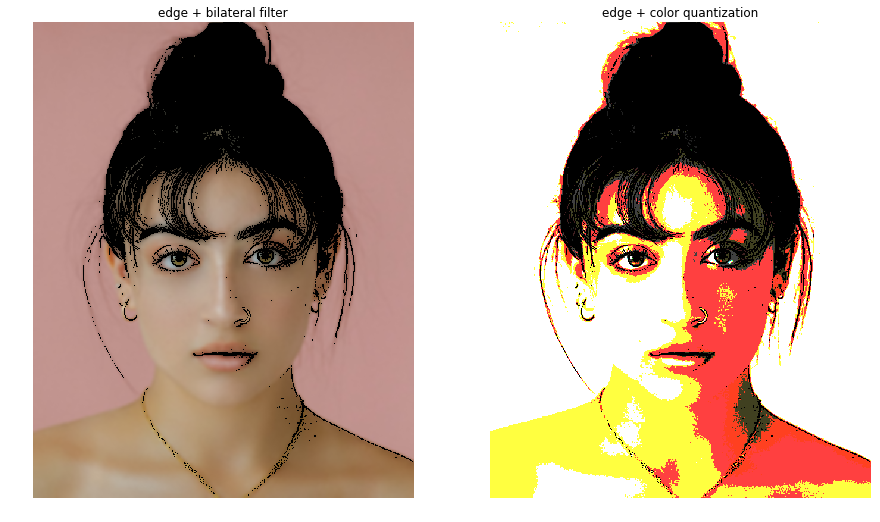

In [101]:
plt.figure(figsize=(15,15)) 
plt.subplot(121)
plt.imshow(img_out1)
plt.title("edge + bilateral filter")
plt.axis('off')
plt.subplot(122)
plt.imshow(img_out2)
plt.title("edge + color quantization")
plt.axis('off')
plt.show()

## Second example

(-0.5, 639.5, 959.5, -0.5)

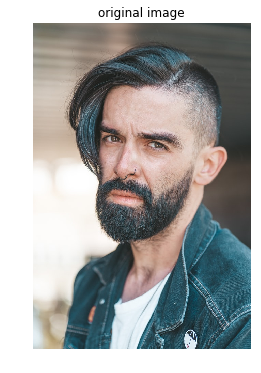

In [102]:
# load the image
filename = "image/joackim-weiler-lxX0dJQHV3w-unsplash.jpg"
img = cv.imread(filename)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(6,6)) 
plt.imshow(img_rgb, cmap="gray", vmin=0, vmax=255)
plt.title("original image")
plt.axis('off')

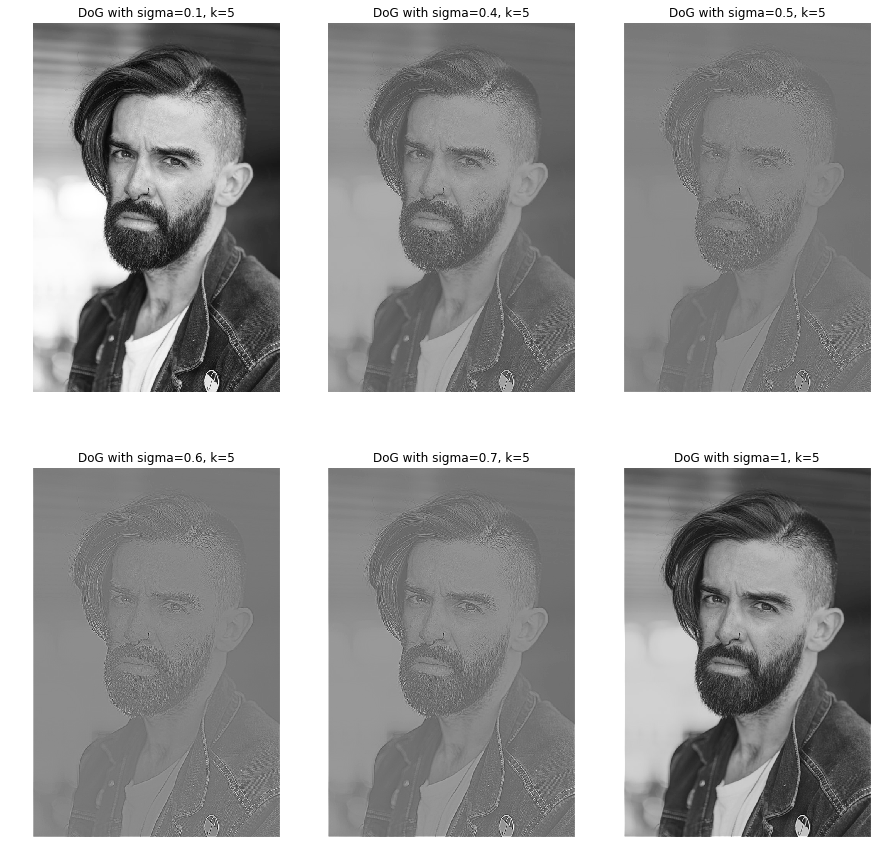

In [103]:
plt.figure(figsize=(15,15)) 
for idx,sigma in enumerate([0.1, 0.4, 0.5, 0.6, 0.7, 1]):
    dog = Dog(img_gray, 5, 1.6,  sigma, 0.98)
    plt.subplot(2,3,idx+1)
    plt.imshow(dog, cmap="gray")
    plt.title('DoG with sigma=' + str(sigma) + ', k=' + str(5))
    plt.axis('off')

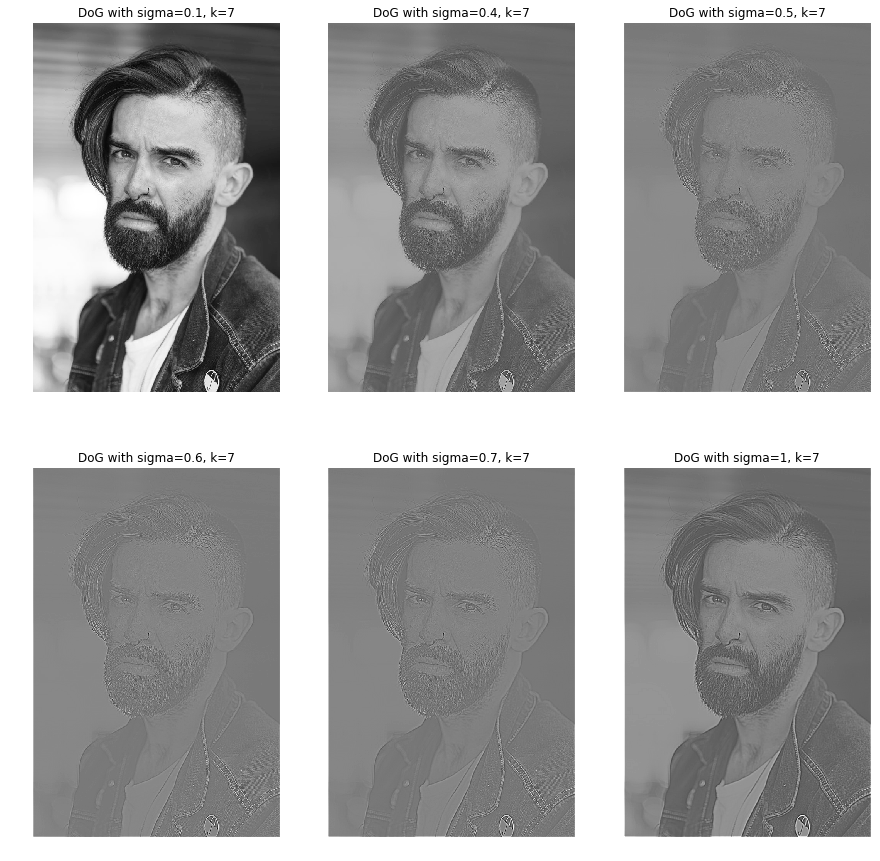

In [104]:
plt.figure(figsize=(15,15)) 
for idx,sigma in enumerate([0.1, 0.4, 0.5, 0.6, 0.7, 1]):
    dog = Dog(img_gray, 7, 1.6,  sigma, 0.98)
    plt.subplot(2,3,idx+1)
    plt.imshow(dog, cmap="gray")
    plt.title('DoG with sigma=' + str(sigma) + ', k=' + str(7))
    plt.axis('off')

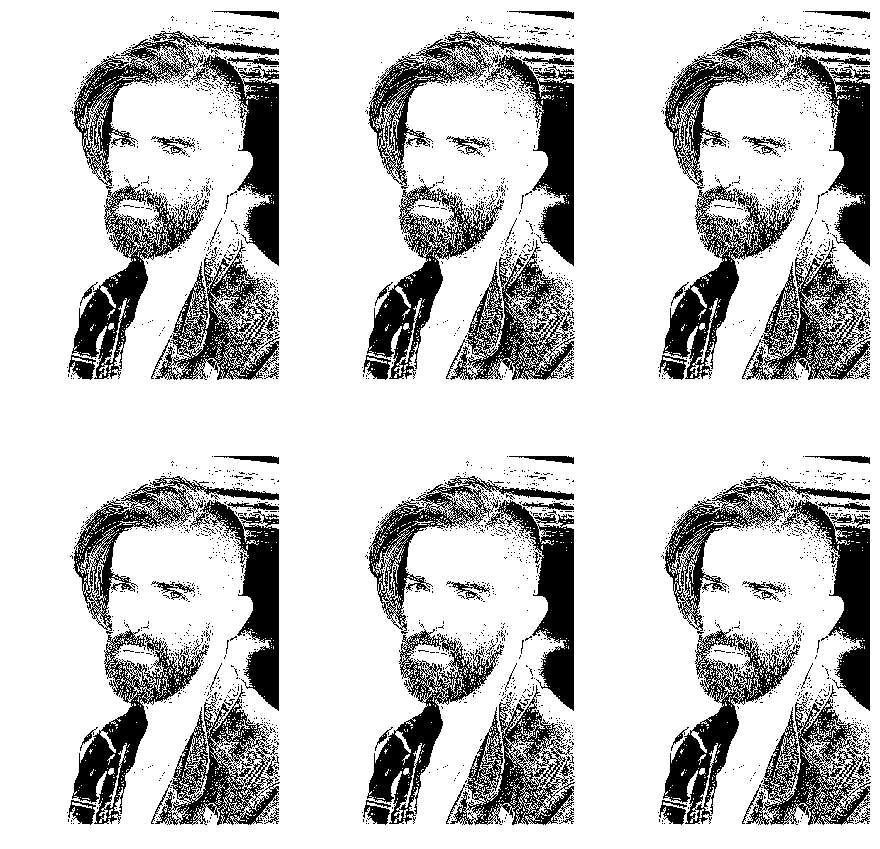

In [112]:
img_dog = Dog(img_gray, 5, 1.6,  0.7, 0.98)

plt.figure(figsize=(15,15)) 
for idx,epsilon in enumerate([-0.5, -0.1, 0.1, 0.5, 0.6, 0.9]):
    dog_t = soft_threshold(img_dog, epsilon, 0.3)
    dog_tt = mean_threshold(dog_t)
    plt.subplot(2,3,idx+1)
    plt.imshow(255 - dog_tt, cmap="gray")
    plt.title('DoG (0.6,7);' + 'epsilon=' + str(epsilon) + '; phi=0.3')
    plt.axis('off')

In [106]:
img_color_smooth = cv.bilateralFilter(img_rgb, d=9, sigmaColor=150, sigmaSpace=150)
img_color_qt = color_quantization(img_rgb)

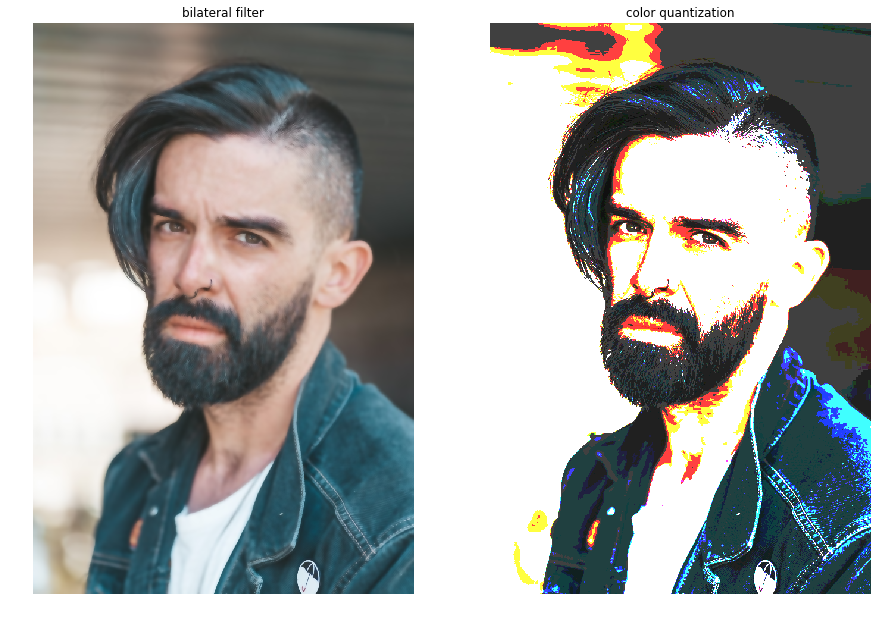

In [107]:
plt.figure(figsize=(15,15)) 
plt.subplot(121)
plt.imshow(img_color_smooth)
plt.title("bilateral filter")
plt.axis('off')
plt.subplot(122)
plt.imshow(img_color_qt)
plt.title("color quantization")
plt.axis('off')
plt.show()

In [108]:
dog_t = soft_threshold(img_dog, 0.5, 0.3)
dog_tt = mean_threshold(dog_t)
img_out1 = combine_color_edges(img_color_smooth, dog_tt)
img_out2 = combine_color_edges(img_color_qt, dog_tt) 

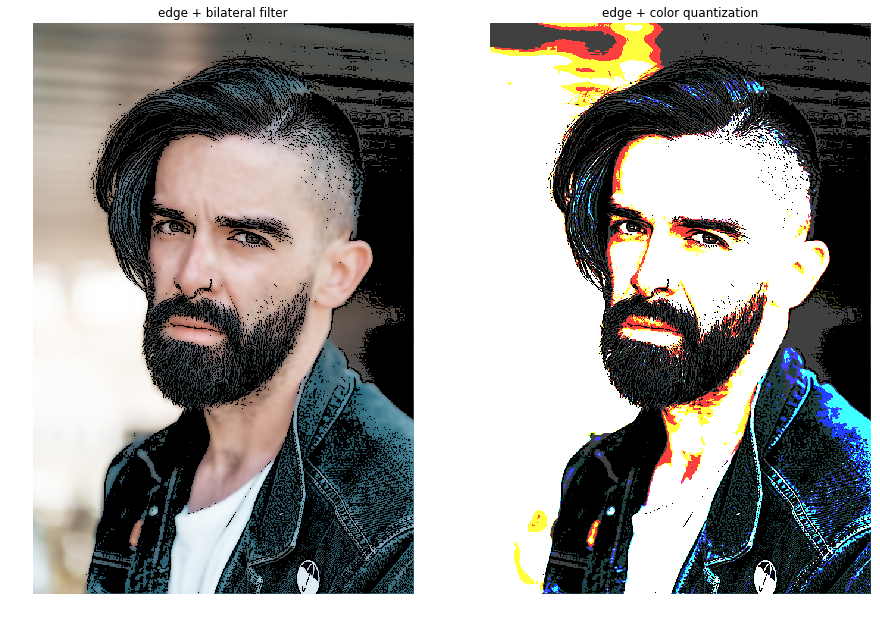

In [109]:
plt.figure(figsize=(15,15)) 
plt.subplot(121)
plt.imshow(img_out1)
plt.title("edge + bilateral filter")
plt.axis('off')
plt.subplot(122)
plt.imshow(img_out2)
plt.title("edge + color quantization")
plt.axis('off')
plt.show()

# Other images...

In [119]:
def display(filename):
    img = cv.imread(filename)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    plt.figure(figsize=(15,15)) 
    plt.subplot(131)
    plt.imshow(img_rgb)
    plt.title("original image")
    plt.axis('off')
    
    img_dog = Dog(img_gray, 5, 1.6,  0.7, 0.98)
    
    img_color_smooth = cv.bilateralFilter(img_rgb, d=9, sigmaColor=150, sigmaSpace=150)
    img_color_qt = color_quantization(img_rgb)
    
    dog_t = soft_threshold(img_dog, 0.5, 0.3)
    dog_tt = mean_threshold(dog_t)
    img_out1 = combine_color_edges(img_color_smooth, dog_tt)
    img_out2 = combine_color_edges(img_color_qt, dog_tt) 
    
    plt.subplot(132)
    plt.imshow(img_out1)
    plt.title("edge + bilateral filter")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img_out2)
    plt.title("edge + color quantization")
    plt.axis('off')
    plt.show()

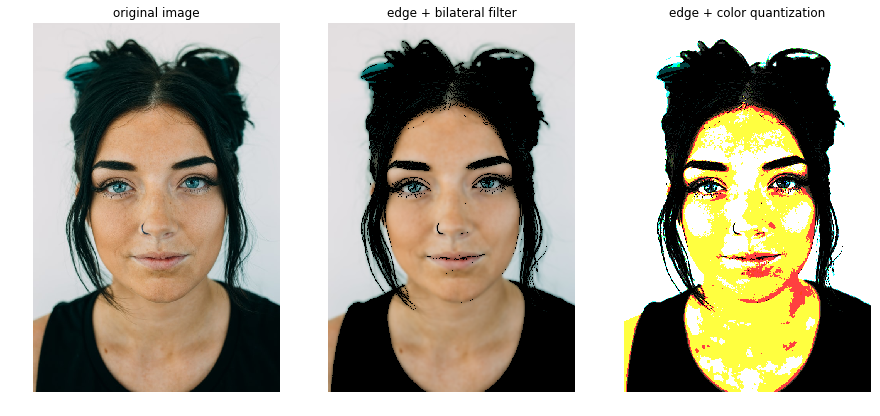

In [120]:
filename = "image/hassan-khan-EGVccebWodM-unsplash.jpg"
display(filename)

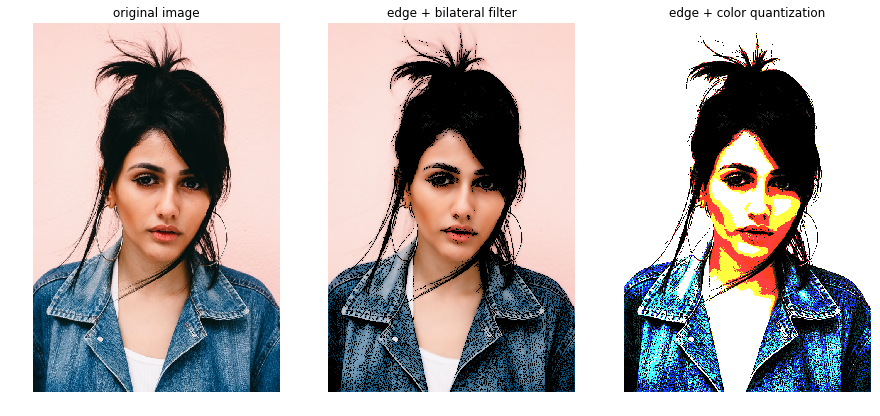

In [122]:
filename = "image/matheus-ferrero-W7b3eDUb_2I-unsplash.jpg"
display(filename)

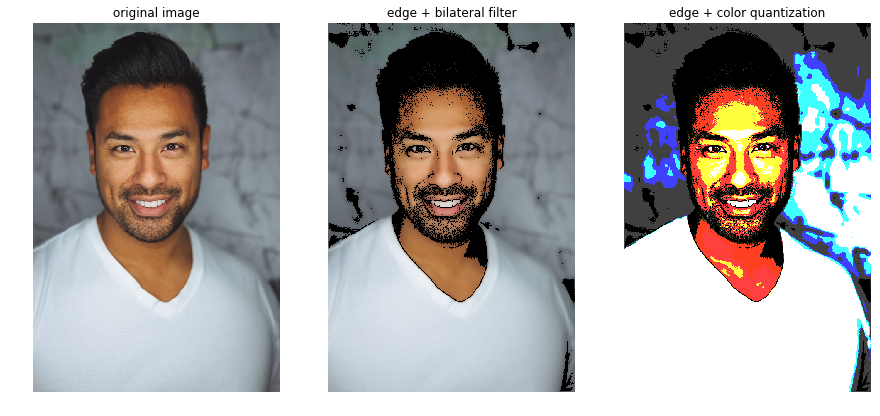

In [121]:
filename = "image/joseph-gonzalez-iFgRcqHznqg-unsplash.jpg"
display(filename)

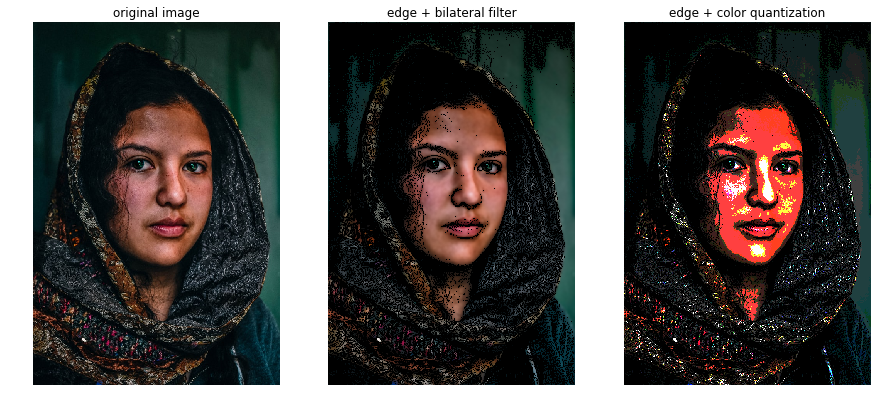

In [123]:
filename = "image/mathilda-khoo-vLR0YP_otCo-unsplash.jpg"
display(filename)

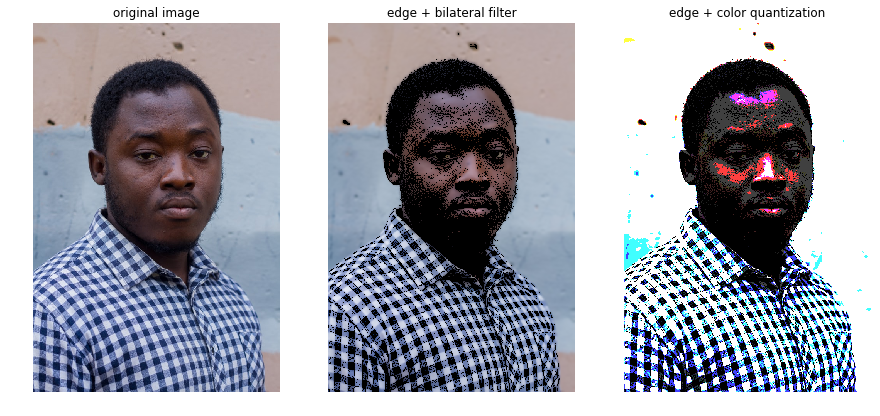

In [124]:
filename = "image/david-rotimi-6hGIMs-TOYU-unsplash.jpg"
display(filename)

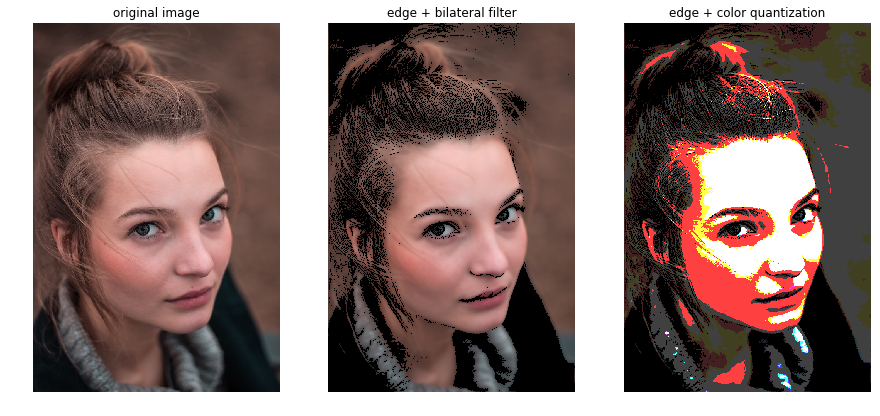

In [125]:
filename = "image/almos-bechtold-3402kvtHhOo-unsplash.jpg"
display(filename)